In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam
import matplotlib.pyplot as plt
import pickle
import sys; sys.path.insert(0, "..")
from game import *
from agents import *
from checkers import *

In [2]:
n_features = 34
feature_func = checkers_features_augmented

reward_function = checkers_reward
reverse_reward_function = reverse_checkers_reward

ab1 = AlphaBetaAgent(1)
ab2 = AlphaBetaAgent(2)
ab3 = AlphaBetaAgent(3)
rand_agent = RandomAgent()
# second_agent_list = [ab1, ab2, ab3, rand_agent]
second_agent_list = [ab1, rand_agent]

ab1_r = AlphaBetaAgent(1, reward_direction=-1)
ab2_r = AlphaBetaAgent(2, reward_direction=-1)
ab3_r = AlphaBetaAgent(3, reward_direction=-1)        
# second_agent_list_post_reversal = [ab1_r, ab2_r, ab3_r, rand_agent]
second_agent_list_post_reversal = [ab1_r, rand_agent]

quiet = True
n_train_games = 500
n_train_games_post_reversal = 500
max_moves = 500
n_decay = 1
n_games_test = 10
test_frequency = 10
max_random_start_depth_train = 3
max_random_start_depth_test = 3
gamma = 0.7
initial_alpha = 0.001
initial_epsilon = 0.35
min_alpha = 1e-5
min_epsilon = 0.01
alpha_decay_rate = 0.995
epsilon_decay_rate = 0.995
alpha_recovery_rate = 1.05
epsilon_recovery_rate = 1.05

w1 = 100
w2 = 10
sd_frac = 0.5

In [3]:
pool_results = []
pool_draws = []
pool_oppn_idx = []
pool_weights = []
pool_rewards = []
pool_td = []
pool_num = []
pool_test_results_rand = []
pool_test_results_1 = []
pool_test_results_2 = []
pool_test_results_3 = []
pool_test_draws_rand = []
pool_test_draws_1 = []
pool_test_draws_2 = []
pool_test_draws_3 = []

pool_td1_mean = []
pool_td1_sd = []
pool_td2_mean = []

pool_alpha = []
pool_epsilon = []
    
for i_trial in range(10):
    print('Trial =', i_trial)
    
    np.random.seed(i_trial)
    initial_weights = np.random.normal(size=n_features)
    first_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reward_function, 
                                     alpha=initial_alpha, gamma=gamma, epsilon=initial_epsilon, 
                                     is_learning_agent=True, weights=initial_weights)

    all_results = []
    all_draws = []
    all_oppn_idx = []
    all_weights = []
    all_rewards = []
    all_td = []
    all_num = []
    test_results_rand = []
    test_results_1 = []
    test_results_2 = []
    test_results_3 = []
    test_draws_rand = []
    test_draws_1 = []
    test_draws_2 = []
    test_draws_3 = []
    
    all_td1_mean = []
    all_td1_sd = []
    all_td2_mean = []
    all_alpha = []
    all_epsilon = []

    # pre-training test
    this_test_results_rand = []
    this_test_results_1 = []
    this_test_results_2 = []
    this_test_results_3 = []

    this_test_draws_rand = []
    this_test_draws_1 = []
    this_test_draws_2 = []
    this_test_draws_3 = []

    for n in range(n_games_test):
        test_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reward_function, alpha=0., gamma=gamma, epsilon=initial_epsilon, is_learning_agent=False, weights=initial_weights)
        # play against ab1
        first_agent_turn = bool(np.random.binomial(1,0.5))
        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(test_agent, ab1, first_agent_turn, quiet=quiet)

        # random start
        random_start_spots = game.game_state.board.spots
        for _ in range(np.random.choice(max_random_start_depth_test)*2):
            possible_moves = game.game_state.board.get_possible_next_moves()
            next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
            game.game_state.board.make_move(next_move, switch_player_turn=True)
            random_start_spots = game.game_state.board.spots

        num_moves, game_state = game.run()
        this_test_results_1.append(game_state.is_first_agent_win())
        this_test_draws_1.append(game_state.max_moves_done)

#         # play against ab2
#         first_agent_turn = bool(np.random.binomial(1,0.5))
#         rules = ClassicGameRules(max_moves=max_moves)
#         game = rules.new_game(test_agent, ab2, first_agent_turn, quiet=quiet)
#         game.game_state.board.spots = random_start_spots # set start board position to the same random start
#         num_moves, game_state = game.run()
#         this_test_results_2.append(game_state.is_first_agent_win())
#         this_test_draws_2.append(game_state.max_moves_done)

#         # play against ab3
#         first_agent_turn = bool(np.random.binomial(1,0.5))
#         rules = ClassicGameRules(max_moves=max_moves)
#         game = rules.new_game(test_agent, ab3, first_agent_turn, quiet=quiet)
#         game.game_state.board.spots = random_start_spots # set start board position to the same random start
#         num_moves, game_state = game.run()
#         this_test_results_3.append(game_state.is_first_agent_win())
#         this_test_draws_3.append(game_state.max_moves_done)

        # play against random agent
        first_agent_turn = bool(np.random.binomial(1,0.5))
        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet)
        game.game_state.board.spots = random_start_spots # set start board position to the same random start
        num_moves, game_state = game.run()
        this_test_results_rand.append(game_state.is_first_agent_win())
        this_test_draws_rand.append(game_state.max_moves_done)

    test_results_1.append(np.mean(np.array(this_test_results_1)))
#     test_results_2.append(np.mean(np.array(this_test_results_2)))
#     test_results_3.append(np.mean(np.array(this_test_results_3)))
    test_results_rand.append(np.mean(np.array(this_test_results_rand)))

    test_draws_1.append(np.mean(np.array(this_test_draws_1)))
#     test_draws_2.append(np.mean(np.array(this_test_draws_2)))
#     test_draws_3.append(np.mean(np.array(this_test_draws_3)))
    test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))


    # training with standard rule
    for n in range(n_train_games):
        if n > w1:
            mean_td_1 = np.mean(all_td[-w1:])
            sd_td_1 = np.std(all_td[-w1:])
            mean_td_2 = np.mean(all_td[-w2:])
            
            all_td1_mean.append(mean_td_1)
            all_td1_sd.append(sd_td_1)
            all_td2_mean.append(mean_td_2)
#             # increase learning rate if TD decreased
#             if mean_td_2 < (mean_td_1 - sd_frac*sd_td_1):
#                 factor = (mean_td_1 - mean_td_2)/(sd_frac*sd_td_1)
#                 current_alpha = first_agent.alpha
#                 current_epsilon = first_agent.epsilon
#                 first_agent.alpha = min([(alpha_recovery_rate**factor)*current_alpha, initial_alpha])
#                 first_agent.epsilon = min([(alpha_recovery_rate**factor)*current_epsilon, initial_epsilon])
#                 print('Ajusting alpha from {0:.6f} to {1:.6f}'.format(current_alpha,first_agent.alpha))
#                 print('Ajusting epsilon from {0:.6f} to {1:.6f}'.format(current_epsilon,first_agent.epsilon))
                
            # change alpha and epsilon after n_decay games
            if n%n_decay == n_decay-1:
                first_agent.alpha = max([alpha_decay_rate*first_agent.alpha, min_alpha])
                first_agent.epsilon = max([epsilon_decay_rate*first_agent.epsilon, min_epsilon])

#         if n%50 == 0: print(n)
        # train against randomly selected agent
        first_agent_turn = bool(np.random.binomial(1,0.5))

        second_agent_idx = np.random.choice(len(second_agent_list))  
        all_oppn_idx.append(second_agent_idx)
        second_agent = second_agent_list[second_agent_idx]

        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(first_agent, second_agent, first_agent_turn, quiet=quiet)    

        # random start
        for _ in range(np.random.choice(max_random_start_depth_train)*2):
            possible_moves = game.game_state.board.get_possible_next_moves()
            next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
            game.game_state.board.make_move(next_move, switch_player_turn=True)

        num_moves, game_state = game.run()

        all_num.append(num_moves)
        all_rewards.append(first_agent.episode_rewards)
        all_td.append(first_agent.episode_td_history[-1])
        all_results.append(game_state.is_first_agent_win())
        all_draws.append((game_state.max_moves_done))
        all_weights.append(first_agent.weights.copy())
        all_alpha.append(first_agent.alpha)
        all_epsilon.append(first_agent.epsilon)

        if n%test_frequency == test_frequency-1:

            this_test_results_rand = []
            this_test_results_1 = []
            this_test_results_2 = []
            this_test_results_3 = []

            this_test_draws_rand = []
            this_test_draws_1 = []
            this_test_draws_2 = []
            this_test_draws_3 = []

            for _ in range(n_games_test):
                current_epislon = first_agent.epsilon
                test_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reward_function, alpha=0., gamma=gamma, epsilon=current_epislon, is_learning_agent=False, weights=all_weights[-1])
                # play against ab1
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab1, first_agent_turn, quiet=quiet)

                # random start
                random_start_spots = game.game_state.board.spots
                for _ in range(np.random.choice(max_random_start_depth_test)*2):
                    possible_moves = game.game_state.board.get_possible_next_moves()
                    next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
                    game.game_state.board.make_move(next_move, switch_player_turn=True)
                    random_start_spots = game.game_state.board.spots

                num_moves, game_state = game.run()
                this_test_results_1.append(game_state.is_first_agent_win())
                this_test_draws_1.append(game_state.max_moves_done)

#                 # play against ab2
#                 first_agent_turn = bool(np.random.binomial(1,0.5))
#                 rules = ClassicGameRules(max_moves=max_moves)
#                 game = rules.new_game(test_agent, ab2, first_agent_turn, quiet=quiet)
#                 game.game_state.board.spots = random_start_spots # set start board position to the same random start
#                 num_moves, game_state = game.run()
#                 this_test_results_2.append(game_state.is_first_agent_win())
#                 this_test_draws_2.append(game_state.max_moves_done)

#                 # play against ab3
#                 first_agent_turn = bool(np.random.binomial(1,0.5))
#                 rules = ClassicGameRules(max_moves=max_moves)
#                 game = rules.new_game(test_agent, ab3, first_agent_turn, quiet=quiet)
#                 game.game_state.board.spots = random_start_spots # set start board position to the same random start
#                 num_moves, game_state = game.run()
#                 this_test_results_3.append(game_state.is_first_agent_win())
#                 this_test_draws_3.append(game_state.max_moves_done)

                # play against random agent
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_rand.append(game_state.is_first_agent_win())
                this_test_draws_rand.append(game_state.max_moves_done)

            test_results_1.append(np.mean(np.array(this_test_results_1)))
#             test_results_2.append(np.mean(np.array(this_test_results_2)))
#             test_results_3.append(np.mean(np.array(this_test_results_3)))
            test_results_rand.append(np.mean(np.array(this_test_results_rand)))

            test_draws_1.append(np.mean(np.array(this_test_draws_1)))
#             test_draws_2.append(np.mean(np.array(this_test_draws_2)))
#             test_draws_3.append(np.mean(np.array(this_test_draws_3)))
            test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))

            print('Post game', n,'wins = ',test_results_1[-1],test_results_rand[-1])    
            print('Post game', n,'draws = ',test_draws_1[-1],test_draws_rand[-1]) 
            
#             print('Post game', n, 'wins = ',test_results_1[-1],test_results_2[-1],test_results_3[-1],test_results_rand[-1])    
#             print('Post game', n,'draws = ',test_draws_1[-1],test_draws_2[-1],test_draws_3[-1],test_draws_rand[-1])  
            
  
    
    #### set reverse rule (in ClassicGameRules.new_game)
    reverse = True

    # RL agent: takes reverse reward
    first_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reverse_reward_function, 
                                     alpha=all_alpha[-1], gamma=gamma, epsilon=all_epsilon[-1], 
                                     is_learning_agent=True, weights=all_weights[n_train_games-1])
    
    # train with reverse rule
    for n in range(n_train_games_post_reversal):    
        # start readjusting mechanism immediately
        mean_td_1 = np.mean(all_td[-w1:])
        sd_td_1 = np.std(all_td[-w1:])
        mean_td_2 = np.mean(all_td[-w2:])

        all_td1_mean.append(mean_td_1)
        all_td1_sd.append(sd_td_1)
        all_td2_mean.append(mean_td_2)

#         # increase learning rate if TD decreased
#         if mean_td_2 < (mean_td_1 - sd_frac*sd_td_1):
#             factor = (mean_td_1 - mean_td_2)/(sd_frac*sd_td_1)
#             current_alpha = first_agent.alpha
#             current_epsilon = first_agent.epsilon
#             first_agent.alpha = min([(alpha_recovery_rate**factor)*current_alpha, initial_alpha])
#             first_agent.epsilon = min([(alpha_recovery_rate**factor)*current_epsilon, initial_epsilon])
#             print('Ajusting alpha from {0:.6f} to {1:.6f}'.format(current_alpha,first_agent.alpha))
#             print('Ajusting epsilon from {0:.6f} to {1:.6f}'.format(current_epsilon,first_agent.epsilon))

        # change alpha and epsilon after n_decay games
        if n%n_decay == n_decay-1:
            first_agent.alpha = max([alpha_decay_rate*first_agent.alpha, min_alpha])
            first_agent.epsilon = max([epsilon_decay_rate*first_agent.epsilon, min_epsilon])
        # train against randomly selected agent
        first_agent_turn = bool(np.random.binomial(1,0.5))

        second_agent_idx = np.random.choice(len(second_agent_list_post_reversal))  
        all_oppn_idx.append(second_agent_idx)
        second_agent = second_agent_list_post_reversal[second_agent_idx]

        rules = ClassicGameRules(max_moves=max_moves)
        game = rules.new_game(first_agent, second_agent, first_agent_turn, quiet=quiet, reverse=reverse)    

        # random start
        for _ in range(np.random.choice(max_random_start_depth_train)*2):
            possible_moves = game.game_state.board.get_possible_next_moves()
            next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
            game.game_state.board.make_move(next_move, switch_player_turn=True)

        num_moves, game_state = game.run()

        all_num.append(num_moves)
        all_rewards.append(first_agent.episode_rewards)
        all_results.append(game_state.is_first_agent_win())
        all_td.append(first_agent.episode_td_history[-1])
        all_draws.append((game_state.max_moves_done))
        all_weights.append(first_agent.weights.copy())
        all_alpha.append(first_agent.alpha)
        all_epsilon.append(first_agent.epsilon)

        if n%test_frequency == test_frequency-1:

            this_test_results_rand = []
            this_test_results_1 = []
            this_test_results_2 = []
            this_test_results_3 = []

            this_test_draws_rand = []
            this_test_draws_1 = []
            this_test_draws_2 = []
            this_test_draws_3 = []

            for _ in range(n_games_test):
                current_epislon = first_agent.epsilon
                test_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reverse_checkers_reward, 
                                                alpha=0., gamma=gamma, epsilon=current_epislon, 
                                                is_learning_agent=False, weights=all_weights[-1])
                # play against ab1_r
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, ab1_r, first_agent_turn, quiet=quiet, reverse=reverse)

                # random start
                random_start_spots = game.game_state.board.spots
                for _ in range(np.random.choice(max_random_start_depth_test)*2):
                    possible_moves = game.game_state.board.get_possible_next_moves()
                    next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
                    game.game_state.board.make_move(next_move, switch_player_turn=reverse)
                    random_start_spots = game.game_state.board.spots

                num_moves, game_state = game.run()
                this_test_results_1.append(game_state.is_first_agent_win())
                this_test_draws_1.append(game_state.max_moves_done)

#                 # play against ab2_r
#                 first_agent_turn = bool(np.random.binomial(1,0.5))
#                 rules = ClassicGameRules(max_moves=max_moves)
#                 game = rules.new_game(test_agent, ab2_r, first_agent_turn, quiet=quiet, reverse=reverse)
#                 game.game_state.board.spots = random_start_spots # set start board position to the same random start
#                 num_moves, game_state = game.run()
#                 this_test_results_2.append(game_state.is_first_agent_win())
#                 this_test_draws_2.append(game_state.max_moves_done)

#                 # play against ab3_r
#                 first_agent_turn = bool(np.random.binomial(1,0.5))
#                 rules = ClassicGameRules(max_moves=max_moves)
#                 game = rules.new_game(test_agent, ab3_r, first_agent_turn, quiet=quiet, reverse=reverse)
#                 game.game_state.board.spots = random_start_spots # set start board position to the same random start
#                 num_moves, game_state = game.run()
#                 this_test_results_3.append(game_state.is_first_agent_win())
#                 this_test_draws_3.append(game_state.max_moves_done)

                # play against random agent
                first_agent_turn = bool(np.random.binomial(1,0.5))
                rules = ClassicGameRules(max_moves=max_moves)
                game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet, reverse=True)
                game.game_state.board.spots = random_start_spots # set start board position to the same random start
                num_moves, game_state = game.run()
                this_test_results_rand.append(game_state.is_first_agent_win())
                this_test_draws_rand.append(game_state.max_moves_done)

            test_results_1.append(np.mean(np.array(this_test_results_1)))
#             test_results_2.append(np.mean(np.array(this_test_results_2)))
#             test_results_3.append(np.mean(np.array(this_test_results_3)))
            test_results_rand.append(np.mean(np.array(this_test_results_rand)))

            test_draws_1.append(np.mean(np.array(this_test_draws_1)))
#             test_draws_2.append(np.mean(np.array(this_test_draws_2)))
#             test_draws_3.append(np.mean(np.array(this_test_draws_3)))
            test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))

            print('Post reverse game', n,'wins = ',test_results_1[-1],test_results_rand[-1])    
            print('Post reverse game', n,'draws = ',test_draws_1[-1],test_draws_rand[-1]) 
            
#             print('Post reverse game', n,'wins = ',test_results_1[-1],test_results_2[-1],test_results_3[-1],test_results_rand[-1])    
#             print('Post reverse game', n,'draws = ',test_draws_1[-1],test_draws_2[-1],test_draws_3[-1],test_draws_rand[-1]) 
        
#     data = {'all_results':all_results,
#             'all_draws':all_draws,
#             'all_oppn_idx':all_oppn_idx,
#             'all_num':all_num,
#             'all_weights':all_weights,
#             'all_rewards':all_rewards,
#             'all_td':all_td,
#             'test_results_rand':test_results_rand,
#             'test_results_1':test_results_1,
#             'test_results_2':test_results_2,
#             'test_results_3':test_results_3,
#             'test_draws_rand':test_draws_rand,
#             'test_draws_1':test_draws_1,
#             'test_draws_2':test_draws_2,
#             'test_draws_3':test_draws_3}
    
#     filename = 'Results_{0}_Experiment_SARSA_33_features_checker_reward_mix_oppn_reverse_rule_at_1000_manual_tuning_alpha_eps.pkl'.format(i_trial)
#     with open(filename, "wb") as f:
#         pickle.dump(data, f)

    pool_results.append(all_results)
    pool_draws.append(all_draws)
    pool_oppn_idx.append(all_oppn_idx)
    pool_weights.append(all_weights)
    pool_rewards.append(all_rewards)
    pool_td.append(all_td)
    pool_num.append(all_num)
    pool_test_results_rand.append(test_results_rand)
    pool_test_results_1.append(test_results_1)
    pool_test_draws_rand.append(test_draws_rand)
    pool_test_draws_1.append(test_draws_1)
    pool_td1_mean.append(all_td1_mean)
    pool_td1_sd.append(all_td1_sd)
    pool_td2_mean.append(all_td2_mean)
    pool_alpha.append(all_alpha)
    pool_epsilon.append(all_epsilon)

Trial = 0
Post game 9 wins =  0.4 0.5
Post game 9 draws =  0.1 0.0
Post game 19 wins =  0.8 1.0
Post game 19 draws =  0.0 0.0
Post game 29 wins =  0.9 0.9
Post game 29 draws =  0.1 0.0
Post game 39 wins =  0.9 1.0
Post game 39 draws =  0.1 0.0
Post game 49 wins =  0.7 1.0
Post game 49 draws =  0.3 0.0
Post game 59 wins =  0.2 0.4
Post game 59 draws =  0.2 0.1
Post game 69 wins =  0.9 1.0
Post game 69 draws =  0.1 0.0
Post game 79 wins =  0.7 1.0
Post game 79 draws =  0.3 0.0
Post game 89 wins =  0.9 1.0
Post game 89 draws =  0.1 0.0
Post game 99 wins =  0.7 1.0
Post game 99 draws =  0.2 0.0
Post game 109 wins =  0.8 1.0
Post game 109 draws =  0.2 0.0
Post game 119 wins =  0.9 1.0
Post game 119 draws =  0.1 0.0
Post game 129 wins =  1.0 1.0
Post game 129 draws =  0.0 0.0
Post game 139 wins =  0.7 1.0
Post game 139 draws =  0.3 0.0
Post game 149 wins =  0.2 0.7
Post game 149 draws =  0.5 0.0
Post game 159 wins =  0.5 0.9
Post game 159 draws =  0.4 0.0
Post game 169 wins =  0.4 1.0
Post g

Post game 229 wins =  0.8 1.0
Post game 229 draws =  0.2 0.0
Post game 239 wins =  0.4 1.0
Post game 239 draws =  0.6 0.0
Post game 249 wins =  0.4 0.9
Post game 249 draws =  0.6 0.0
Post game 259 wins =  0.7 1.0
Post game 259 draws =  0.3 0.0
Post game 269 wins =  0.6 1.0
Post game 269 draws =  0.4 0.0
Post game 279 wins =  0.8 1.0
Post game 279 draws =  0.1 0.0
Post game 289 wins =  0.8 1.0
Post game 289 draws =  0.2 0.0
Post game 299 wins =  0.7 1.0
Post game 299 draws =  0.2 0.0
Post game 309 wins =  0.0 0.4
Post game 309 draws =  0.2 0.0
Post game 319 wins =  0.5 1.0
Post game 319 draws =  0.5 0.0
Post game 329 wins =  0.6 1.0
Post game 329 draws =  0.0 0.0
Post game 339 wins =  0.8 0.9
Post game 339 draws =  0.2 0.0
Post game 349 wins =  0.6 1.0
Post game 349 draws =  0.3 0.0
Post game 359 wins =  0.6 0.8
Post game 359 draws =  0.3 0.0
Post game 369 wins =  0.0 0.4
Post game 369 draws =  0.8 0.1
Post game 379 wins =  0.7 0.8
Post game 379 draws =  0.3 0.0
Post game 389 wins =  0.

Post game 449 wins =  0.8 1.0
Post game 449 draws =  0.2 0.0
Post game 459 wins =  0.6 1.0
Post game 459 draws =  0.2 0.0
Post game 469 wins =  0.6 0.8
Post game 469 draws =  0.1 0.0
Post game 479 wins =  0.6 0.8
Post game 479 draws =  0.0 0.0
Post game 489 wins =  0.7 0.9
Post game 489 draws =  0.0 0.0
Post game 499 wins =  0.6 1.0
Post game 499 draws =  0.4 0.0
Post reverse game 9 wins =  0.0 0.1
Post reverse game 9 draws =  0.3 0.0
Post reverse game 19 wins =  0.0 0.0
Post reverse game 19 draws =  0.1 0.0
Post reverse game 29 wins =  0.0 0.0
Post reverse game 29 draws =  0.2 0.0
Post reverse game 39 wins =  0.0 0.0
Post reverse game 39 draws =  0.1 0.0
Post reverse game 49 wins =  0.0 0.0
Post reverse game 49 draws =  0.3 0.0
Post reverse game 59 wins =  0.0 0.0
Post reverse game 59 draws =  0.1 0.0
Post reverse game 69 wins =  0.0 0.0
Post reverse game 69 draws =  0.1 0.0
Post reverse game 79 wins =  0.0 0.0
Post reverse game 79 draws =  0.2 0.0
Post reverse game 89 wins =  0.0 0.0

Post reverse game 139 wins =  0.0 0.0
Post reverse game 139 draws =  0.2 0.0
Post reverse game 149 wins =  0.0 0.0
Post reverse game 149 draws =  0.1 0.0
Post reverse game 159 wins =  0.0 0.0
Post reverse game 159 draws =  0.3 0.0
Post reverse game 169 wins =  0.0 0.0
Post reverse game 169 draws =  0.2 0.1
Post reverse game 179 wins =  0.0 0.0
Post reverse game 179 draws =  0.6 0.0
Post reverse game 189 wins =  0.0 0.0
Post reverse game 189 draws =  0.3 0.0
Post reverse game 199 wins =  0.0 0.1
Post reverse game 199 draws =  0.5 0.0
Post reverse game 209 wins =  0.0 0.0
Post reverse game 209 draws =  0.3 0.0
Post reverse game 219 wins =  0.0 0.0
Post reverse game 219 draws =  0.4 0.1
Post reverse game 229 wins =  0.0 0.0
Post reverse game 229 draws =  0.2 0.0
Post reverse game 239 wins =  0.0 0.1
Post reverse game 239 draws =  0.3 0.0
Post reverse game 249 wins =  0.0 0.0
Post reverse game 249 draws =  0.6 0.0
Post reverse game 259 wins =  0.0 0.1
Post reverse game 259 draws =  0.2 0.0

Post reverse game 319 wins =  0.0 0.0
Post reverse game 319 draws =  0.0 0.0
Post reverse game 329 wins =  0.0 0.0
Post reverse game 329 draws =  0.1 0.0
Post reverse game 339 wins =  0.0 0.0
Post reverse game 339 draws =  0.1 0.0
Post reverse game 349 wins =  0.0 0.0
Post reverse game 349 draws =  0.0 0.0
Post reverse game 359 wins =  0.0 0.0
Post reverse game 359 draws =  0.2 0.1
Post reverse game 369 wins =  0.0 0.0
Post reverse game 369 draws =  0.1 0.0
Post reverse game 379 wins =  0.0 0.0
Post reverse game 379 draws =  0.2 0.0
Post reverse game 389 wins =  0.0 0.0
Post reverse game 389 draws =  0.2 0.0
Post reverse game 399 wins =  0.0 0.0
Post reverse game 399 draws =  0.0 0.0
Post reverse game 409 wins =  0.0 0.0
Post reverse game 409 draws =  0.1 0.0
Post reverse game 419 wins =  0.0 0.0
Post reverse game 419 draws =  0.3 0.0
Post reverse game 429 wins =  0.0 0.0
Post reverse game 429 draws =  0.3 0.0
Post reverse game 439 wins =  0.0 0.0
Post reverse game 439 draws =  0.0 0.0

Post reverse game 499 wins =  0.0 0.1
Post reverse game 499 draws =  0.2 0.0
Trial = 6
Post game 9 wins =  0.4 0.8
Post game 9 draws =  0.4 0.1
Post game 19 wins =  0.7 1.0
Post game 19 draws =  0.3 0.0
Post game 29 wins =  0.2 0.6
Post game 29 draws =  0.2 0.1
Post game 39 wins =  0.7 1.0
Post game 39 draws =  0.3 0.0
Post game 49 wins =  1.0 1.0
Post game 49 draws =  0.0 0.0
Post game 59 wins =  0.0 0.6
Post game 59 draws =  0.4 0.1
Post game 69 wins =  0.3 1.0
Post game 69 draws =  0.6 0.0
Post game 79 wins =  0.9 1.0
Post game 79 draws =  0.1 0.0
Post game 89 wins =  0.8 1.0
Post game 89 draws =  0.2 0.0
Post game 99 wins =  0.3 0.7
Post game 99 draws =  0.3 0.0
Post game 109 wins =  0.7 0.9
Post game 109 draws =  0.0 0.0
Post game 119 wins =  0.3 1.0
Post game 119 draws =  0.5 0.0
Post game 129 wins =  0.7 1.0
Post game 129 draws =  0.3 0.0
Post game 139 wins =  0.8 1.0
Post game 139 draws =  0.2 0.0
Post game 149 wins =  0.1 0.3
Post game 149 draws =  0.5 0.0
Post game 159 wins =

Post game 219 wins =  0.8 1.0
Post game 219 draws =  0.2 0.0
Post game 229 wins =  0.8 1.0
Post game 229 draws =  0.2 0.0
Post game 239 wins =  0.7 1.0
Post game 239 draws =  0.3 0.0
Post game 249 wins =  0.9 0.8
Post game 249 draws =  0.1 0.0
Post game 259 wins =  0.1 0.3
Post game 259 draws =  0.2 0.0
Post game 269 wins =  0.6 0.7
Post game 269 draws =  0.1 0.0
Post game 279 wins =  0.3 0.6
Post game 279 draws =  0.3 0.0
Post game 289 wins =  0.7 1.0
Post game 289 draws =  0.3 0.0
Post game 299 wins =  0.9 1.0
Post game 299 draws =  0.0 0.0
Post game 309 wins =  0.9 0.9
Post game 309 draws =  0.1 0.1
Post game 319 wins =  0.5 0.8
Post game 319 draws =  0.4 0.0
Post game 329 wins =  0.4 0.9
Post game 329 draws =  0.3 0.0
Post game 339 wins =  0.9 1.0
Post game 339 draws =  0.1 0.0
Post game 349 wins =  0.9 1.0
Post game 349 draws =  0.1 0.0
Post game 359 wins =  0.5 1.0
Post game 359 draws =  0.5 0.0
Post game 369 wins =  0.8 1.0
Post game 369 draws =  0.2 0.0
Post game 379 wins =  0.

Post game 439 wins =  0.8 1.0
Post game 439 draws =  0.1 0.0
Post game 449 wins =  1.0 1.0
Post game 449 draws =  0.0 0.0
Post game 459 wins =  0.8 0.9
Post game 459 draws =  0.2 0.0
Post game 469 wins =  0.8 1.0
Post game 469 draws =  0.2 0.0
Post game 479 wins =  0.9 1.0
Post game 479 draws =  0.1 0.0
Post game 489 wins =  0.8 1.0
Post game 489 draws =  0.2 0.0
Post game 499 wins =  0.8 1.0
Post game 499 draws =  0.2 0.0
Post reverse game 9 wins =  0.0 0.0
Post reverse game 9 draws =  0.0 0.0
Post reverse game 19 wins =  0.0 0.1
Post reverse game 19 draws =  0.8 0.1
Post reverse game 29 wins =  0.0 0.0
Post reverse game 29 draws =  0.5 0.0
Post reverse game 39 wins =  0.0 0.1
Post reverse game 39 draws =  0.5 0.0
Post reverse game 49 wins =  0.0 0.0
Post reverse game 49 draws =  0.3 0.0
Post reverse game 59 wins =  0.0 0.0
Post reverse game 59 draws =  0.3 0.0
Post reverse game 69 wins =  0.1 0.3
Post reverse game 69 draws =  0.3 0.0
Post reverse game 79 wins =  0.0 0.0
Post reverse 

Post reverse game 129 wins =  0.0 0.0
Post reverse game 129 draws =  0.2 0.0
Post reverse game 139 wins =  0.0 0.0
Post reverse game 139 draws =  0.1 0.0
Post reverse game 149 wins =  0.0 0.0
Post reverse game 149 draws =  0.1 0.0
Post reverse game 159 wins =  0.0 0.0
Post reverse game 159 draws =  0.0 0.0
Post reverse game 169 wins =  0.0 0.0
Post reverse game 169 draws =  0.2 0.0
Post reverse game 179 wins =  0.0 0.0
Post reverse game 179 draws =  0.2 0.0
Post reverse game 189 wins =  0.0 0.0
Post reverse game 189 draws =  0.1 0.0
Post reverse game 199 wins =  0.0 0.0
Post reverse game 199 draws =  0.0 0.0
Post reverse game 209 wins =  0.0 0.1
Post reverse game 209 draws =  0.2 0.1
Post reverse game 219 wins =  0.0 0.0
Post reverse game 219 draws =  0.1 0.0
Post reverse game 229 wins =  0.0 0.0
Post reverse game 229 draws =  0.2 0.0
Post reverse game 239 wins =  0.0 0.0
Post reverse game 239 draws =  0.1 0.0
Post reverse game 249 wins =  0.0 0.0
Post reverse game 249 draws =  0.3 0.0

In [4]:
data = {'pool_results':pool_results,
        'pool_draws':pool_draws,
        'pool_oppn_idx':pool_oppn_idx,
        'pool_weights':pool_weights,
        'pool_num':pool_num,
        'pool_rewards':pool_rewards,
        'pool_td':pool_td,
        'pool_test_results_rand':pool_test_results_rand,
        'pool_test_results_1':pool_test_results_1,
        'pool_test_draws_rand':pool_test_draws_rand,
        'pool_test_draws_1':pool_test_draws_1,
        'pool_td1_mean':pool_td1_mean,
        'pool_td1_sd':pool_td1_sd,
        'pool_td2_mean':pool_td2_mean,
        'pool_alpha':pool_alpha,
        'pool_epsilon':pool_epsilon}
with open(r"Experiment_dynamic_adjustment_of_alpha_and_epsilon_rand_and_AB1_control_group.pkl", "wb") as f:
    pickle.dump(data, f)

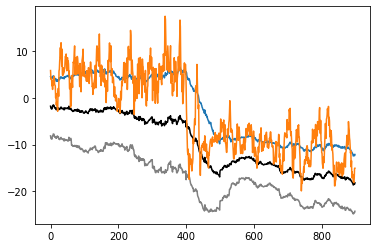

In [5]:
plt.plot(all_td1_mean)
plt.plot(np.array(all_td1_mean)-0.5*np.array(all_td1_sd),'k')
plt.plot(np.array(all_td1_mean)-np.array(all_td1_sd),color='gray')
plt.plot(all_td2_mean)

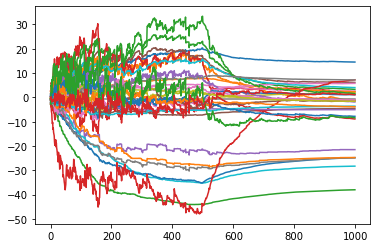

In [6]:
all_weights_array = np.stack(all_weights)
np.squeeze(all_weights_array).shape
plt.plot(np.squeeze(all_weights_array));

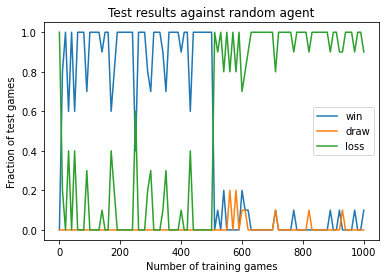

In [7]:
loss_rand = 1-np.array(test_results_rand)-np.array(test_draws_rand)
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_results_rand,label='win'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_draws_rand,label='draw'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),loss_rand,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against random agent');

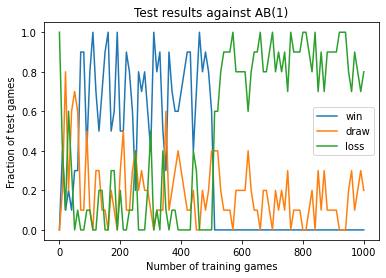

In [8]:
loss_1 = 1-np.array(test_results_1)-np.array(test_draws_1)
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_results_1,label='win'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),test_draws_1,label='draw'),
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),loss_1,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(1)');

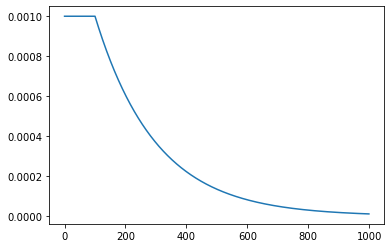

In [9]:
plt.plot(range(1000), all_alpha)

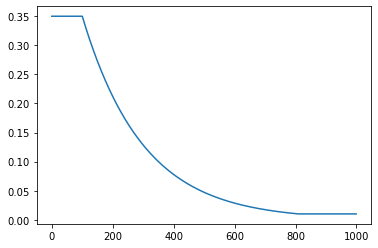

In [10]:
plt.plot(range(1000), all_epsilon)

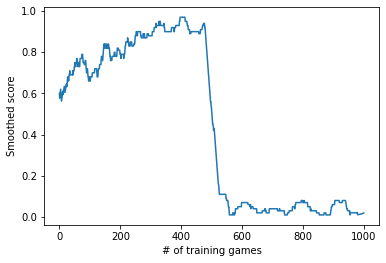

In [11]:
w = 50
calib = np.convolve(np.ones(n_train_games+n_train_games_post_reversal), np.ones(w), 'same')
all_score = 1*np.array(all_results) + 0.5*np.array(all_draws)
mean_smooth_score = np.convolve(all_score, np.ones(w), 'same') / calib
plt.plot(mean_smooth_score)
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');

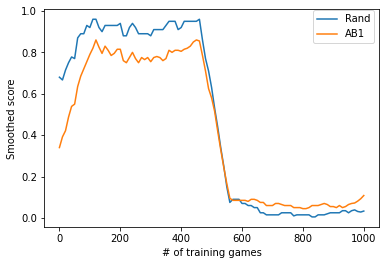

In [12]:
w = 10
calib = np.convolve(np.ones(len(test_results_rand)), np.ones(w), 'same')
all_score_rand = 1*np.array(test_results_rand) + 0.5*np.array(test_draws_rand)
all_score_1 = 1*np.array(test_results_1) + 0.5*np.array(test_draws_1)

mean_smooth_score_rand = np.convolve(all_score_rand, np.ones(w), 'same') / calib
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),mean_smooth_score_rand, label='Rand')
mean_smooth_score_1 = np.convolve(all_score_1, np.ones(w), 'same') / calib
plt.plot(np.arange(0,n_train_games+n_train_games_post_reversal+1,test_frequency),mean_smooth_score_1, label='AB1')
plt.legend(bbox_to_anchor=(1,1.02))
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');